In [285]:
library(ggrastr)
library(patchwork)
library(dplyr)
library(data.table)
library(ggplot2)
library(tidyr)
library(readxl)
library(survival)
library(meta)
library(grid)

# GWAS

In [4]:
summstat <- fread("data/IL7_multi_manhattan.gz")
summstat <- summstat %>% rename(chr=CHR, pos=BP, p=P)

Joining, by = "chr"
`summarise()` has grouped output by 'chr'. You can override using the `.groups`
argument.


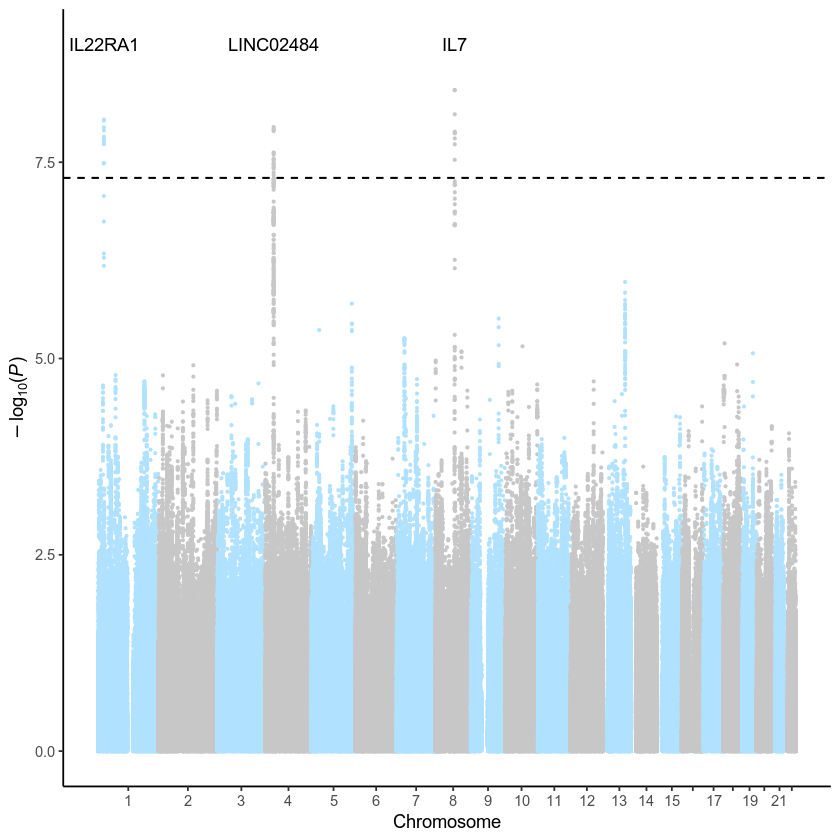

In [7]:
summstat$chr <- factor(summstat$chr,levels=as.character(1:22))
breaks <- summstat %>% group_by(chr) %>%
                summarise(min=min(pos), max=max(pos)) %>%
                rowwise %>% mutate(center=mean(c(min,max))) %>%
                ungroup
temp <- breaks %>% mutate(cumsum=cumsum(as.numeric(max)), cumsum=lag(cumsum)) %>% select(chr,cumsum)

summstat <- inner_join(summstat,temp) %>%
    mutate(manhattan_pos=pos+cumsum) %>%
    mutate(manhattan_pos=ifelse(is.na(manhattan_pos),pos,manhattan_pos)) %>% select(-cumsum)

breaks <- summstat %>% group_by(chr) %>%
                summarise(min=min(manhattan_pos), max=max(manhattan_pos)) %>%
                rowwise %>% mutate(center=mean(c(min,max))) %>%
                ungroup
names <- summstat %>% group_by(chr) %>%
        summarise(pos=manhattan_pos[p<5e-8 & p==min(p)]) %>%
        ungroup %>%
        mutate(name=c("IL22RA1", "LINC02484", "IL7"))

colour1="lightskyblue1"
colour2="grey78"

ggplot(summstat,aes(x=manhattan_pos,y=-log10(p),colour=as.character(chr))) + 
    geom_hline(yintercept=-log10(5e-8),linetype="dashed") +
    geom_point(size=0.5) +
    scale_colour_manual(values=c("1"=colour1,"2"=colour2,"3"=colour1,"4"=colour2,"5"=colour1,"6"=colour2,"7"=colour1,"8"=colour2,"9"=colour1,"10"=colour2,"11"=colour1,"12"=colour2,"13"=colour1,"14"=colour2,"15"=colour1,"16"=colour2,"17"=colour1,"18"=colour2,"19"=colour1,"20"=colour2,"21"=colour1,"22"=colour2))+ # not cool though
    theme_classic()+
    theme(legend.position="NONE")+
    scale_x_continuous(breaks=breaks$center,labels=c(1:15,"",17,"",19,"",21,""))+
    xlab("Chromosome")+
    ylab(expression(paste(-log[10],"(",italic(P), ")")))+
    geom_hline(yintercept=-log10(5e-8),linetype="dashed") + 
    geom_text(data=names, aes(x=pos+20000,y=-log10(1e-9),label=name), color="black")

# Association of top SNPs

In [70]:
allgrade <- read_excel("data/Tables.xlsx", sheet=17) %>%
        rename(SEX=`SEX (self-identified)`) %>%
        mutate(PANEL_VERSION = as.factor(PANEL_VERSION), 
               LINE_OF_TREATMENT = ifelse(LINE_OF_TREATMENT>2,">2",LINE_OF_TREATMENT)
              )
allgrade$TREATMENT_CUM <- factor(allgrade$TREATMENT_CUM)
allgrade$TREATMENT_CUM <- relevel(allgrade$TREATMENT_CUM, "PD1_PDL1")
allgrade$LINE_OF_TREATMENT <- factor(allgrade$LINE_OF_TREATMENT)
allgrade$LINE_OF_TREATMENT <- relevel(allgrade$LINE_OF_TREATMENT, "1")

### Direct association

We are only looking at the transition to adverse events here and use the competing transition to death only as a censoring event.

In [71]:
temp <- allgrade %>% filter(trans!=3) %>%
        group_by(ID) %>% summarise(
            Tstart = first(Tstart),
            Tstop = first(Tstop),
            irAE=ifelse((trans %*% status)[1]==1,1,0),
            across(names(allgrade)[6:length(names(allgrade))],first) 
        )

Using stratification over cancer types:

In [74]:
fit <- coxph(Surv(Tstart,Tstop,irAE) ~ strata(CANCER_TYPE) + PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS + rs16906115_norm, temp)
summary(fit)
cox.zph(fit)

fit <- coxph(Surv(Tstart,Tstop,irAE) ~ strata(CANCER_TYPE) + PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS + rs75824728_norm, temp)
summary(fit)
cox.zph(fit)

fit <- coxph(Surv(Tstart,Tstop,irAE) ~ strata(CANCER_TYPE) + PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS + rs113861051_norm, temp)
summary(fit)
cox.zph(fit)

Call:
coxph(formula = Surv(Tstart, Tstop, irAE) ~ strata(CANCER_TYPE) + 
    PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + 
    START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + 
    ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS + 
    rs16906115_norm, data = temp)

  n= 1702, number of events= 290 

                                   coef  exp(coef)   se(coef)      z Pr(>|z|)
PROFILE_AFTER_TREATMENT       -0.073876   0.928787   0.170046 -0.434   0.6640
SEXMALE                        0.010096   1.010147   0.130853  0.077   0.9385
AGE_AT_TREATMENTSTART          0.017018   1.017164   0.005360  3.175   0.0015
PANEL_VERSION2                 0.017146   1.017294   0.230548  0.074   0.9407
PANEL_VERSION3                -0.102811   0.902297   0.260296 -0.395   0.6929
START_YEAR2017                 0.168037   1.182981   0.193039  0.870   0.3840
START_YEAR2018                 0.310088   1.363545   0.219011  1.416   0.1568
START_YEARa

                           chisq df     p
PROFILE_AFTER_TREATMENT  0.09492  1 0.758
SEX                      2.57522  1 0.109
AGE_AT_TREATMENTSTART    1.89945  1 0.168
PANEL_VERSION            0.16947  2 0.919
START_YEAR               0.67919  4 0.954
LINE_OF_TREATMENT        2.15055  2 0.341
TREATMENT_CUM            5.66621  2 0.059
CONC_CHEMO               0.00493  1 0.944
ANCESTRY_ROT_PC1         0.20310  1 0.652
ANCESTRY_ROT_PC2         0.22080  1 0.638
ANCESTRY_PC_ASH          1.24090  1 0.265
ANCESTRY_PC_NS           1.01706  1 0.313
rs16906115_norm          0.63732  1 0.425
GLOBAL                  23.50005 19 0.216

Call:
coxph(formula = Surv(Tstart, Tstop, irAE) ~ strata(CANCER_TYPE) + 
    PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + 
    START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + 
    ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS + 
    rs75824728_norm, data = temp)

  n= 1702, number of events= 290 

                                  coef exp(coef)  se(coef)      z Pr(>|z|)    
PROFILE_AFTER_TREATMENT       0.026316  1.026665  0.169580  0.155 0.876679    
SEXMALE                       0.001673  1.001674  0.130859  0.013 0.989801    
AGE_AT_TREATMENTSTART         0.018481  1.018653  0.005354  3.452 0.000556 ***
PANEL_VERSION2               -0.138969  0.870255  0.231394 -0.601 0.548124    
PANEL_VERSION3               -0.197903  0.820449  0.259922 -0.761 0.446422    
START_YEAR2017                0.164471  1.178769  0.190841  0.862 0.388786    
START_YEAR2018                0.299578  1.349290  0.216829  1.382 0.167083    
STA

                           chisq df     p
PROFILE_AFTER_TREATMENT  0.03680  1 0.848
SEX                      2.64144  1 0.104
AGE_AT_TREATMENTSTART    2.17161  1 0.141
PANEL_VERSION            0.09987  2 0.951
START_YEAR               0.44931  4 0.978
LINE_OF_TREATMENT        1.98972  2 0.370
TREATMENT_CUM            6.33265  2 0.042
CONC_CHEMO               0.00499  1 0.944
ANCESTRY_ROT_PC1         0.09110  1 0.763
ANCESTRY_ROT_PC2         0.09506  1 0.758
ANCESTRY_PC_ASH          0.76420  1 0.382
ANCESTRY_PC_NS           1.01335  1 0.314
rs75824728_norm          0.19976  1 0.655
GLOBAL                  22.66303 19 0.253

Call:
coxph(formula = Surv(Tstart, Tstop, irAE) ~ strata(CANCER_TYPE) + 
    PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + 
    START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + 
    ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS + 
    rs113861051_norm, data = temp)

  n= 1702, number of events= 290 

                                  coef exp(coef)  se(coef)      z Pr(>|z|)    
PROFILE_AFTER_TREATMENT       0.020128  1.020332  0.170110  0.118  0.90581    
SEXMALE                       0.067241  1.069553  0.131218  0.512  0.60835    
AGE_AT_TREATMENTSTART         0.016822  1.016964  0.005358  3.140  0.00169 ** 
PANEL_VERSION2               -0.026084  0.974253  0.231863 -0.112  0.91043    
PANEL_VERSION3               -0.172951  0.841179  0.262300 -0.659  0.50966    
START_YEAR2017                0.262357  1.299990  0.193810  1.354  0.17584    
START_YEAR2018                0.413714  1.512425  0.220026  1.880  0.06007 .  
ST

                           chisq df     p
PROFILE_AFTER_TREATMENT 6.10e-02  1 0.805
SEX                     2.58e+00  1 0.108
AGE_AT_TREATMENTSTART   1.54e+00  1 0.215
PANEL_VERSION           1.56e-01  2 0.925
START_YEAR              6.95e-01  4 0.952
LINE_OF_TREATMENT       1.96e+00  2 0.374
TREATMENT_CUM           5.69e+00  2 0.058
CONC_CHEMO              8.49e-06  1 0.998
ANCESTRY_ROT_PC1        2.04e-01  1 0.652
ANCESTRY_ROT_PC2        5.26e-02  1 0.819
ANCESTRY_PC_ASH         8.69e-01  1 0.351
ANCESTRY_PC_NS          1.24e+00  1 0.266
rs113861051_norm        1.48e-01  1 0.700
GLOBAL                  2.24e+01 19 0.263

Using meta analysis

Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1,7,8 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  4,5 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,12 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  8,9 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  8 ; beta may be infinite. ”


Number of studies combined: k = 12

                       SMD           95%-CI    z  p-value
Common effect model 0.6685 [0.4200; 0.9171] 5.27 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.1091 [0.0000; 0.3787]; tau = 0.3303 [0.0000; 0.6154]
 I^2 = 0.0% [0.0%; 58.3%]; H = 1.00 [1.00; 1.55]

Test of heterogeneity:
    Q d.f. p-value
 8.63   11  0.6557

Details on meta-analytical method:
- Inverse variance method
- Sidik-Jonkman estimator for tau^2
- Q-profile method for confidence interval of tau^2 and tau

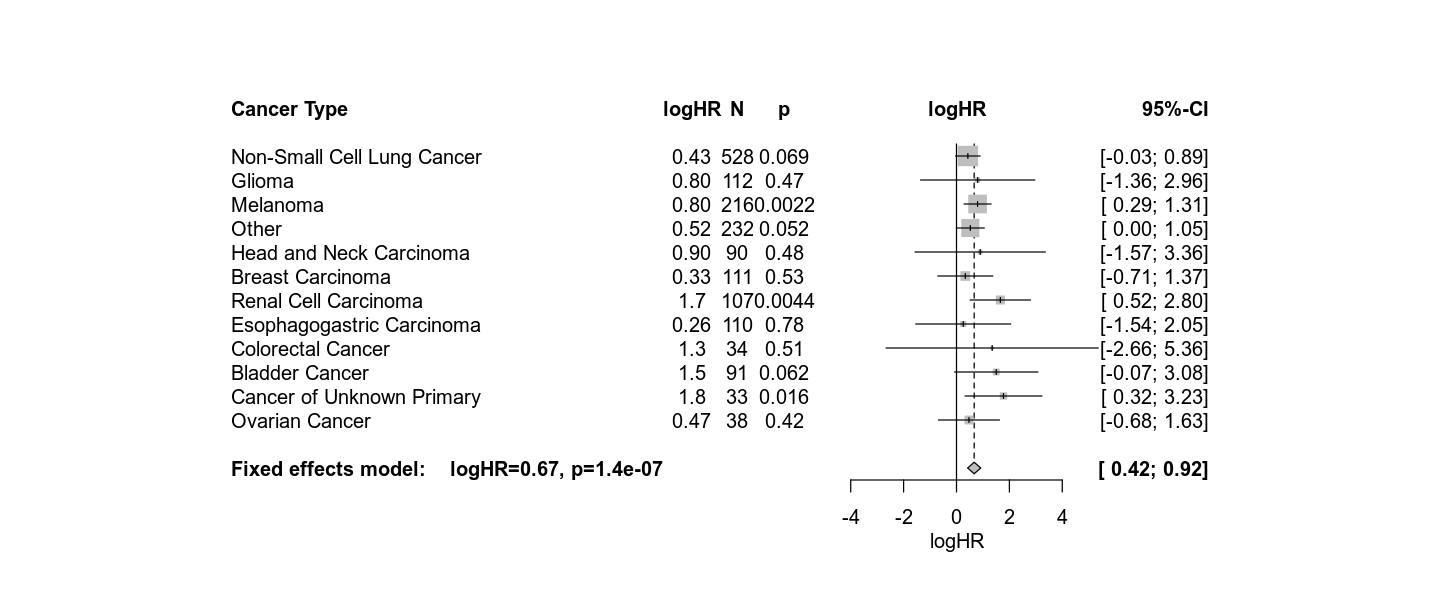

In [509]:
formulas <- list("Glioma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + scale(AGE_AT_TREATMENTSTART) + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Non-Small Cell Lung Cancer"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Melanoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Other"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Head and Neck Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Breast Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Renal Cell Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + strata(SEX) + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Esophagogastric Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + strata(CONC_CHEMO) + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + strata(ANCESTRY_PC_NS)",
                 "Colorectal Cancer"="Surv(Tstart,Tstop,irAE) ~ scale(AGE_AT_TREATMENTSTART) + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Bladder Cancer"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Cancer of Unknown Primary"="Surv(Tstart,Tstop,irAE) ~ SEX + AGE_AT_TREATMENTSTART + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Ovarian Cancer"="Surv(Tstart,Tstop,irAE) ~ AGE_AT_TREATMENTSTART + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS"
                )

meta_df <- data.frame()
for (c in unique(temp$CANCER_TYPE)) {
    form <- formulas[c]
    if (c=="Esophagogastric Carcinoma") {
        fit <- coxph(as.formula(paste0(form," + rs16906115_norm")), temp %>% filter(CANCER_TYPE==c) %>% mutate(ANCESTRY_PC_NS=ntile(ANCESTRY_PC_NS,3)))
    } else {
        fit <- coxph(as.formula(paste0(form," + rs16906115_norm")), temp %>% filter(CANCER_TYPE==c))
    }
    fit <- summary(fit)
    coef <- fit$coefficients[dim(fit$coefficients)[1],"coef"]
    coef_se <- fit$coefficients[dim(fit$coefficients)[1],"se(coef)"]
    pval <- fit$coefficients[dim(fit$coefficients)[1],"Pr(>|z|)"]
    n <- (temp %>% filter(CANCER_TYPE==c) %>% distinct(ID) %>% dim)[1]
    temp_df <- data.frame(cancer=c, coef=coef, coef_se=coef_se, pval=pval, n=n)
    meta_df <- rbind(meta_df,temp_df)
}

meta <- metagen(coef,coef_se,data=meta_df,studlab=paste(cancer),random=F,fixed=T,method.tau = "SJ",hakn = TRUE,prediction=F,sm="SMD")
meta

meta$n_print <- as.character(as.integer(meta_df$n))
meta$pval_print <- as.character(formatC(signif(as.double(meta_df$pval),2),digits=2,format="fg", flag="#"))
meta$TE_print <- as.character(formatC(signif(as.double(meta_df$coef),2),digits=2,format="fg", flag="#"))
options(repr.plot.width=12, repr.plot.height=5)
forest(meta,colgap=unit(0,"points"),comb.random=F,leftcols=c("studlab","TE_print","n_print","pval_print"),leftlabs=c("Cancer Type","logHR","N","p"),rightcols=c("ci"),ref=0,print.tau2=F,print.pval.Q=F,print.I2=F,smlab="logHR",xlab="logHR",text.fixed=paste("Fixed effects model:    logHR=",signif(meta$TE.fixed,2),", p=",signif(meta$pval.fixed,2),sep=""))

Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1,7,8 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  4,5 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,12 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  8,9 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  8 ; beta may be infinite. ”


Number of studies combined: k = 12

                       SMD           95%-CI    z  p-value
Common effect model 0.7141 [0.4652; 0.9631] 5.62 < 0.0001

Quantifying heterogeneity:
 tau^2 = 6.6172 [0.0000; 8.0495]; tau = 2.5724 [0.0000; 2.8372]
 I^2 = 33.3% [0.0%; 66.3%]; H = 1.22 [1.00; 1.72]

Test of heterogeneity:
     Q d.f. p-value
 16.50   11  0.1237

Details on meta-analytical method:
- Inverse variance method
- Sidik-Jonkman estimator for tau^2
- Q-profile method for confidence interval of tau^2 and tau

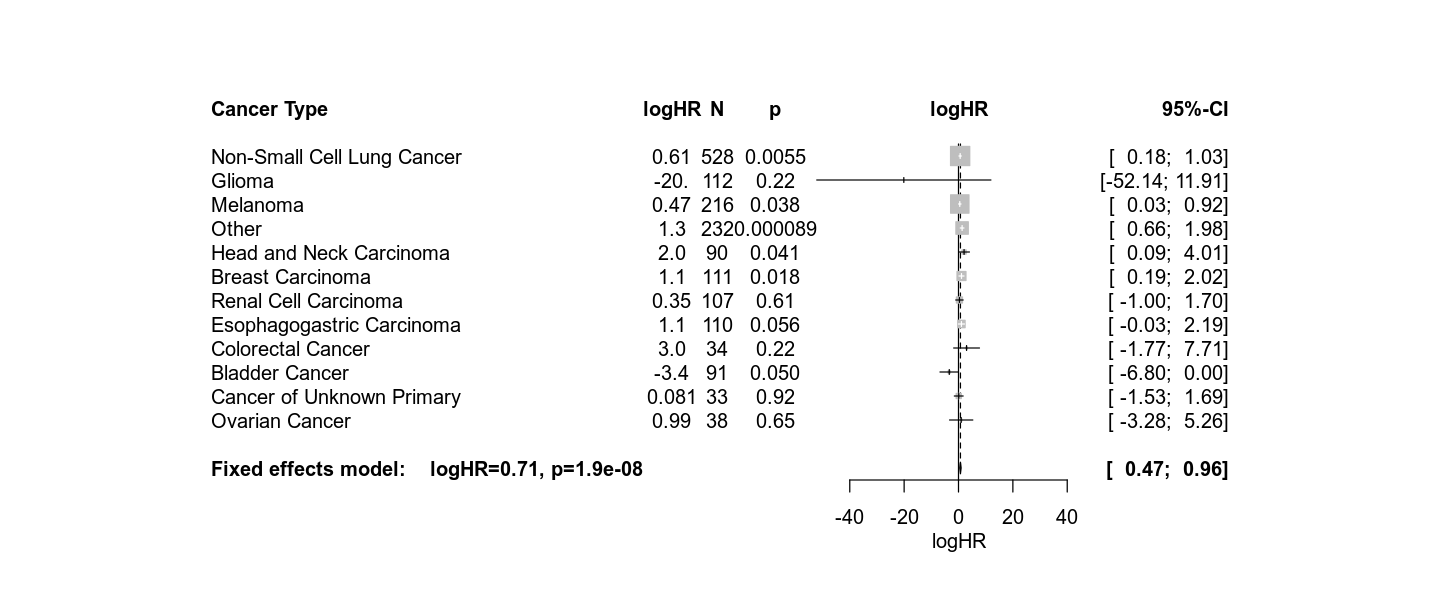

In [341]:
formulas <- list("Glioma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + scale(AGE_AT_TREATMENTSTART) + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Non-Small Cell Lung Cancer"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Melanoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Other"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Head and Neck Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Breast Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Renal Cell Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + strata(SEX) + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Esophagogastric Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + strata(CONC_CHEMO) + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + strata(ANCESTRY_PC_NS)",
                 "Colorectal Cancer"="Surv(Tstart,Tstop,irAE) ~ scale(AGE_AT_TREATMENTSTART) + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Bladder Cancer"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Cancer of Unknown Primary"="Surv(Tstart,Tstop,irAE) ~ SEX + AGE_AT_TREATMENTSTART + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Ovarian Cancer"="Surv(Tstart,Tstop,irAE) ~ AGE_AT_TREATMENTSTART + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS"
                )

meta_df <- data.frame()
for (c in unique(temp$CANCER_TYPE)) {
    form <- formulas[c]
    if (c=="Esophagogastric Carcinoma") {
        fit <- coxph(as.formula(paste0(form," + rs75824728_norm")), temp %>% filter(CANCER_TYPE==c) %>% mutate(ANCESTRY_PC_NS=ntile(ANCESTRY_PC_NS,3)))
    } else {
        fit <- coxph(as.formula(paste0(form," + rs75824728_norm")), temp %>% filter(CANCER_TYPE==c))
    }
    fit <- summary(fit)
    coef <- fit$coefficients[dim(fit$coefficients)[1],"coef"]
    coef_se <- fit$coefficients[dim(fit$coefficients)[1],"se(coef)"]
    pval <- fit$coefficients[dim(fit$coefficients)[1],"Pr(>|z|)"]
    n <- (temp %>% filter(CANCER_TYPE==c) %>% distinct(ID) %>% dim)[1]
    temp_df <- data.frame(cancer=c, coef=coef, coef_se=coef_se, pval=pval, n=n)
    meta_df <- rbind(meta_df,temp_df)
}

meta <- metagen(coef,coef_se,data=meta_df,studlab=paste(cancer),random=F,fixed=T,method.tau = "SJ",hakn = TRUE,prediction=F,sm="SMD")
meta

meta$n_print <- as.character(as.integer(meta_df$n))
meta$pval_print <- as.character(formatC(signif(as.double(meta_df$pval),2),digits=2,format="fg", flag="#"))
meta$TE_print <- as.character(formatC(signif(as.double(meta_df$coef),2),digits=2,format="fg", flag="#"))
options(repr.plot.width=12, repr.plot.height=5)
forest(meta,colgap=unit(0,"points"),comb.random=F,leftcols=c("studlab","TE_print","n_print","pval_print"),leftlabs=c("Cancer Type","logHR","N","p"),rightcols=c("ci"),ref=0,print.tau2=F,print.pval.Q=F,print.I2=F,smlab="logHR",xlab="logHR",text.fixed=paste("Fixed effects model:    logHR=",signif(meta$TE.fixed,2),", p=",signif(meta$pval.fixed,2),sep=""))

Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1,7,8 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  4,5 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,12 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  8,9 ; beta may be infinite. ”
Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  8 ; beta may be infinite. ”


Number of studies combined: k = 12

                       SMD           95%-CI    z  p-value
Common effect model 0.6834 [0.4137; 0.9530] 4.97 < 0.0001

Quantifying heterogeneity:
 tau^2 = 4.7200 [0.0000; 7.4984]; tau = 2.1726 [0.0000; 2.7383]
 I^2 = 26.1% [0.0%; 62.5%]; H = 1.16 [1.00; 1.63]

Test of heterogeneity:
     Q d.f. p-value
 14.88   11  0.1880

Details on meta-analytical method:
- Inverse variance method
- Sidik-Jonkman estimator for tau^2
- Q-profile method for confidence interval of tau^2 and tau

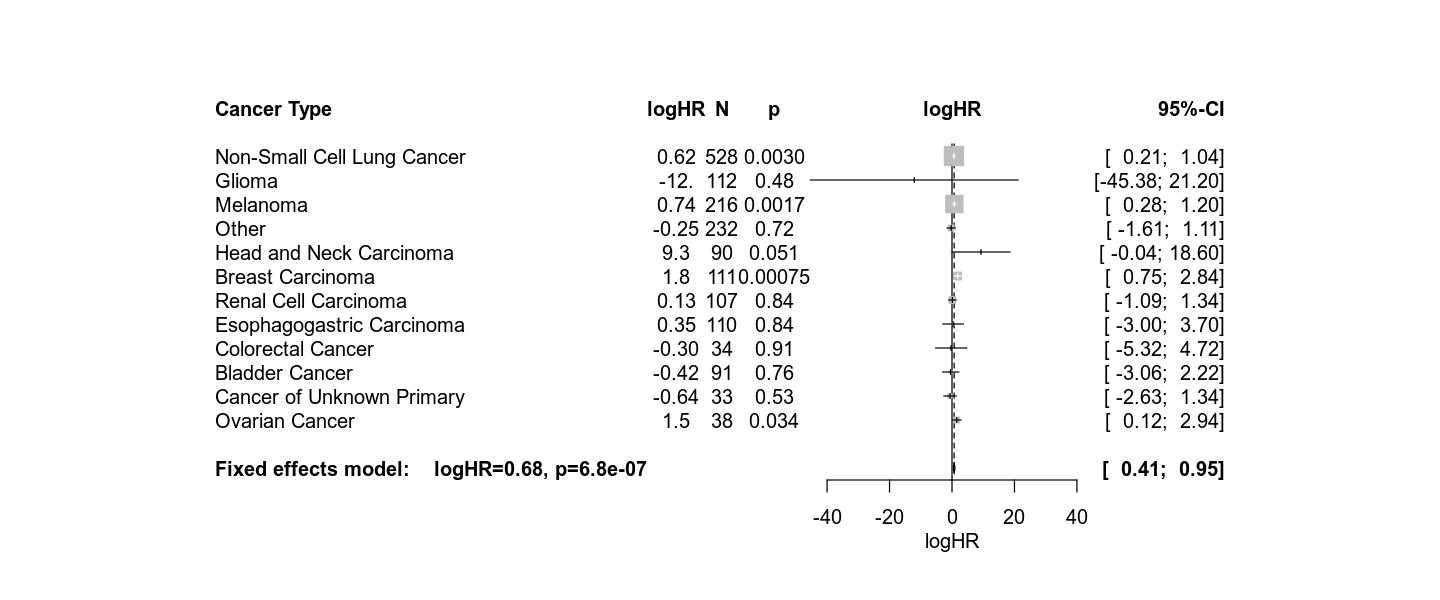

In [342]:
formulas <- list("Glioma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + scale(AGE_AT_TREATMENTSTART) + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Non-Small Cell Lung Cancer"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Melanoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Other"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Head and Neck Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Breast Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Renal Cell Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + strata(SEX) + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Esophagogastric Carcinoma"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + strata(CONC_CHEMO) + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + strata(ANCESTRY_PC_NS)",
                 "Colorectal Cancer"="Surv(Tstart,Tstop,irAE) ~ scale(AGE_AT_TREATMENTSTART) + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Bladder Cancer"="Surv(Tstart,Tstop,irAE) ~ PROFILE_AFTER_TREATMENT + SEX + AGE_AT_TREATMENTSTART + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + TREATMENT_CUM + CONC_CHEMO + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Cancer of Unknown Primary"="Surv(Tstart,Tstop,irAE) ~ SEX + AGE_AT_TREATMENTSTART + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS",
                 "Ovarian Cancer"="Surv(Tstart,Tstop,irAE) ~ AGE_AT_TREATMENTSTART + ANCESTRY_ROT_PC1 + ANCESTRY_ROT_PC2 + ANCESTRY_PC_ASH + ANCESTRY_PC_NS"
                )

meta_df <- data.frame()
for (c in unique(temp$CANCER_TYPE)) {
    form <- formulas[c]
    if (c=="Esophagogastric Carcinoma") {
        fit <- coxph(as.formula(paste0(form," + rs113861051_norm")), temp %>% filter(CANCER_TYPE==c) %>% mutate(ANCESTRY_PC_NS=ntile(ANCESTRY_PC_NS,3)))
    } else {
        fit <- coxph(as.formula(paste0(form," + rs113861051_norm")), temp %>% filter(CANCER_TYPE==c))
    }
    fit <- summary(fit)
    coef <- fit$coefficients[dim(fit$coefficients)[1],"coef"]
    coef_se <- fit$coefficients[dim(fit$coefficients)[1],"se(coef)"]
    pval <- fit$coefficients[dim(fit$coefficients)[1],"Pr(>|z|)"]
    n <- (temp %>% filter(CANCER_TYPE==c) %>% distinct(ID) %>% dim)[1]
    temp_df <- data.frame(cancer=c, coef=coef, coef_se=coef_se, pval=pval, n=n)
    meta_df <- rbind(meta_df,temp_df)
}

meta <- metagen(coef,coef_se,data=meta_df,studlab=paste(cancer),random=F,fixed=T,method.tau = "SJ",hakn = TRUE,prediction=F,sm="SMD")
meta

meta$n_print <- as.character(as.integer(meta_df$n))
meta$pval_print <- as.character(formatC(signif(as.double(meta_df$pval),2),digits=2,format="fg", flag="#"))
meta$TE_print <- as.character(formatC(signif(as.double(meta_df$coef),2),digits=2,format="fg", flag="#"))
options(repr.plot.width=12, repr.plot.height=5)
forest(meta,colgap=unit(0,"points"),comb.random=F,leftcols=c("studlab","TE_print","n_print","pval_print"),leftlabs=c("Cancer Type","logHR","N","p"),rightcols=c("ci"),ref=0,print.tau2=F,print.pval.Q=F,print.I2=F,smlab="logHR",xlab="logHR",text.fixed=paste("Fixed effects model:    logHR=",signif(meta$TE.fixed,2),", p=",signif(meta$pval.fixed,2),sep=""))

### Make multi-state approach

Make the multi-state data

In [510]:
library(mstate)

covs <- c("PROFILE_AFTER_TREATMENT","SEX", "AGE_AT_TREATMENTSTART", "PANEL_VERSION", "START_YEAR", "LINE_OF_TREATMENT", "TREATMENT_CUM", "CONC_CHEMO", "ANCESTRY_ROT_PC1", "ANCESTRY_ROT_PC2", "ANCESTRY_PC_ASH", "ANCESTRY_PC_NS", "rs16906115_norm", "rs75824728_norm", "rs113861051_norm")
tmat <- trans.illdeath()

multi <- allgrade
attributes(multi)$class <- c("msdata","data.frame")
attributes(multi)$trans <- tmat

multi <- expand.covs(multi, covs, longnames = T)

We use the multi-state nature of the problem to gain power, first stratifying by cancer type

In [427]:
form <- "Surv(Tstart,Tstop,status) ~ strata(CANCER_TYPE,trans,PROFILE_AFTER_TREATMENT) + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMCTLA4.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1"

In [428]:
fit <- coxph(as.formula(paste0(form," + rs16906115_norm.1")),multi)
summary(fit)
cox.zph(fit)

fit <- coxph(as.formula(paste0(form," + rs75824728_norm.1")),multi)
summary(fit)
cox.zph(fit)

fit <- coxph(as.formula(paste0(form," + rs113861051_norm.1")),multi)
summary(fit)
cox.zph(fit)

Call:
coxph(formula = as.formula(paste0(form, " + rs16906115_norm.1")), 
    data = multi)

  n= 3743, number of events= 1536 

                                     coef  exp(coef)   se(coef)      z Pr(>|z|)
PANEL_VERSION2                   0.128104   1.136672   0.096496  1.328 0.184322
PANEL_VERSION3                   0.063510   1.065570   0.112110  0.566 0.571055
START_YEAR2017                  -0.127872   0.879966   0.081369 -1.572 0.116065
START_YEAR2018                  -0.143761   0.866095   0.098056 -1.466 0.142617
START_YEARafter2018             -0.356848   0.699879   0.140957 -2.532 0.011354
START_YEARbefore2016             0.180789   1.198162   0.084189  2.147 0.031761
LINE_OF_TREATMENT>2              0.462168   1.587512   0.093144  4.962 6.98e-07
LINE_OF_TREATMENT2               0.183533   1.201454   0.066226  2.771 0.005583
CONC_CHEMOTRUE                   0.321223   1.378813   0.066674  4.818 1.45e-06
SEXMALE.1                       -0.015258   0.984858   0.131478 -0.116 0

                                 chisq df     p
PANEL_VERSION                   4.3919  2 0.111
START_YEAR                      7.0880  4 0.131
LINE_OF_TREATMENT               4.0689  2 0.131
CONC_CHEMO                      0.4849  1 0.486
SEXMALE.1                       2.5164  1 0.113
AGE_AT_TREATMENTSTART.1         2.9468  1 0.086
TREATMENT_CUMCTLA4.1            0.0594  1 0.807
TREATMENT_CUMPD1_CTLA4_combo.1  4.1194  1 0.042
ANCESTRY_ROT_PC1.1              0.4097  1 0.522
ANCESTRY_ROT_PC2.1              0.1938  1 0.660
ANCESTRY_PC_ASH.1               1.5205  1 0.218
ANCESTRY_PC_NS.1                1.0225  1 0.312
rs16906115_norm.1               0.6665  1 0.414
GLOBAL                         32.1945 18 0.021

Call:
coxph(formula = as.formula(paste0(form, " + rs75824728_norm.1")), 
    data = multi)

  n= 3743, number of events= 1536 

                                     coef  exp(coef)   se(coef)      z Pr(>|z|)
PANEL_VERSION2                   0.097015   1.101877   0.096529  1.005 0.314879
PANEL_VERSION3                   0.039027   1.039798   0.112064  0.348 0.727651
START_YEAR2017                  -0.127697   0.880120   0.081217 -1.572 0.115881
START_YEAR2018                  -0.142829   0.866902   0.097862 -1.459 0.144430
START_YEARafter2018             -0.325523   0.722150   0.140826 -2.312 0.020804
START_YEARbefore2016             0.163692   1.177851   0.084115  1.946 0.051649
LINE_OF_TREATMENT>2              0.458681   1.581986   0.093123  4.926 8.41e-07
LINE_OF_TREATMENT2               0.185989   1.204409   0.066236  2.808 0.004985
CONC_CHEMOTRUE                   0.322181   1.380134   0.066533  4.842 1.28e-06
SEXMALE.1                       -0.011754   0.988315   0.131614 -0.089 0

                                 chisq df     p
PANEL_VERSION                   3.9948  2 0.136
START_YEAR                      6.6927  4 0.153
LINE_OF_TREATMENT               4.1068  2 0.128
CONC_CHEMO                      0.4916  1 0.483
SEXMALE.1                       2.6318  1 0.105
AGE_AT_TREATMENTSTART.1         3.7453  1 0.053
TREATMENT_CUMCTLA4.1            0.4063  1 0.524
TREATMENT_CUMPD1_CTLA4_combo.1  4.0966  1 0.043
ANCESTRY_ROT_PC1.1              0.3616  1 0.548
ANCESTRY_ROT_PC2.1              0.0838  1 0.772
ANCESTRY_PC_ASH.1               1.1320  1 0.287
ANCESTRY_PC_NS.1                1.1652  1 0.280
rs75824728_norm.1               0.1514  1 0.697
GLOBAL                         32.5347 18 0.019

Call:
coxph(formula = as.formula(paste0(form, " + rs113861051_norm.1")), 
    data = multi)

  n= 3743, number of events= 1536 

                                     coef  exp(coef)   se(coef)      z Pr(>|z|)
PANEL_VERSION2                   0.119002   1.126372   0.096639  1.231 0.218172
PANEL_VERSION3                   0.050271   1.051556   0.112339  0.447 0.654515
START_YEAR2017                  -0.113278   0.892903   0.081402 -1.392 0.164046
START_YEAR2018                  -0.127486   0.880306   0.098127 -1.299 0.193879
START_YEARafter2018             -0.328849   0.719752   0.140821 -2.335 0.019531
START_YEARbefore2016             0.177641   1.194397   0.084251  2.108 0.034991
LINE_OF_TREATMENT>2              0.463184   1.589126   0.093106  4.975 6.53e-07
LINE_OF_TREATMENT2               0.184023   1.202043   0.066186  2.780 0.005430
CONC_CHEMOTRUE                   0.320357   1.377620   0.066620  4.809 1.52e-06
SEXMALE.1                        0.043947   1.044927   0.131950  0.333 

                                 chisq df     p
PANEL_VERSION                   4.2804  2 0.118
START_YEAR                      7.1643  4 0.127
LINE_OF_TREATMENT               4.0110  2 0.135
CONC_CHEMO                      0.5257  1 0.468
SEXMALE.1                       2.5611  1 0.110
AGE_AT_TREATMENTSTART.1         2.6830  1 0.101
TREATMENT_CUMCTLA4.1            0.0486  1 0.826
TREATMENT_CUMPD1_CTLA4_combo.1  3.9290  1 0.047
ANCESTRY_ROT_PC1.1              0.4413  1 0.507
ANCESTRY_ROT_PC2.1              0.0281  1 0.867
ANCESTRY_PC_ASH.1               1.0800  1 0.299
ANCESTRY_PC_NS.1                1.2761  1 0.259
rs113861051_norm.1              0.0339  1 0.854
GLOBAL                         31.2016 18 0.027

And using meta-analysis over cancer types

Number of studies combined: k = 12

                       SMD           95%-CI    z  p-value
Common effect model 0.7005 [0.4676; 0.9334] 5.90 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.2460 [0.0000; 0.9349]; tau = 0.4960 [0.0000; 0.9669]
 I^2 = 12.2% [0.0%; 52.0%]; H = 1.07 [1.00; 1.44]

Test of heterogeneity:
     Q d.f. p-value
 12.53   11  0.3250

Details on meta-analytical method:
- Inverse variance method
- Sidik-Jonkman estimator for tau^2
- Q-profile method for confidence interval of tau^2 and tau

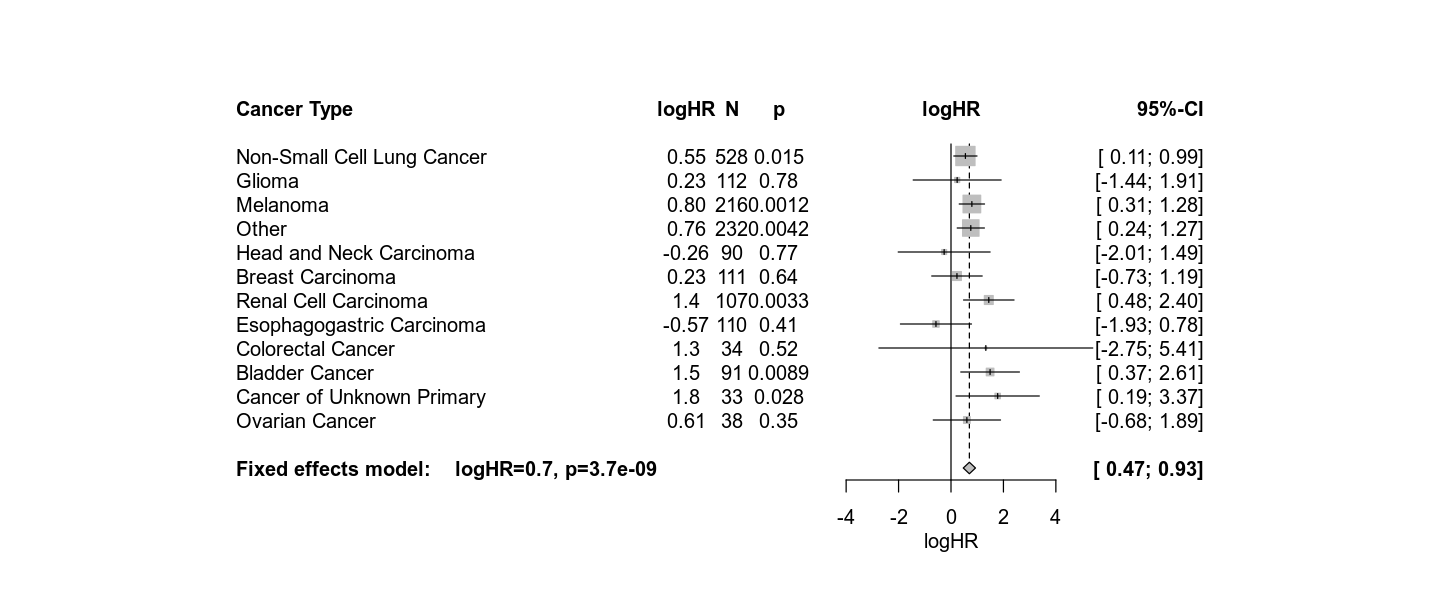

In [553]:
formulas <- list("Non-Small Cell Lung Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Glioma"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Melanoma"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMCTLA4.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Other"="Surv(Tstart,Tstop,status) ~ strata(trans,PANEL_VERSION1) + PANEL_VERSION2 + PROFILE_AFTER_TREATMENT + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMCTLA4.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Head and Neck Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans,START_YEAR2017) + PANEL_VERSION1 + PANEL_VERSION2 + START_YEARbefore2016 + START_YEAR2018 + START_YEARafter2018 + PROFILE_AFTER_TREATMENT + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Breast Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Renal Cell Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans,SEXMALE.1) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Esophagogastric Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans,SEXMALE.1) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1.1",
                 "Colorectal Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans,PROFILE_AFTER_TREATMENT) + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Bladder Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans) + START_YEAR2016 + PROFILE_AFTER_TREATMENT + PANEL_VERSION1 + PANEL_VERSION2 + START_YEAR2017 + START_YEARafter2018 + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Cancer of Unknown Primary"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Ovarian Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEARbefore2016 + START_YEAR2017 + START_YEAR2018 + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1"
                )

meta_df <- data.frame()
for (c in unique(multi$CANCER_TYPE)) {
    form <- formulas[c]
    if (c=="Other") {
        fit <- coxph(as.formula(paste0(form," + rs16906115_norm.1")), multi %>% mutate(PANEL = 1)  %>% pivot_wider(names_from = PANEL_VERSION, values_from = PANEL, values_fill=0, names_prefix="PANEL_VERSION") %>% mutate(ANCESTRY_PC_ASH.1 = as.factor(ntile(ANCESTRY_PC_ASH.1,3))) %>% filter(CANCER_TYPE==c))
    } else if (c=="Esophagogastric Carcinoma") {
        fit <- coxph(as.formula(paste0(form," + rs16906115_norm.1")), multi %>% mutate(ANCESTRY_PC_NS.1 = as.factor(ntile(ANCESTRY_PC_NS.1,2))) %>% mutate(NS = 1)  %>% pivot_wider(names_from = ANCESTRY_PC_NS.1, values_from = NS, values_fill=0, names_prefix="ANCESTRY_PC_NS.1.") %>% filter(CANCER_TYPE==c))
    } else if (c=="Head and Neck Carcinoma") {
        fit <- coxph(as.formula(paste0(form," + rs16906115_norm.1")), multi %>% mutate(PANEL = 1)  %>% pivot_wider(names_from = PANEL_VERSION, values_from = PANEL, values_fill=0, names_prefix="PANEL_VERSION") %>% mutate(START = 1)  %>% pivot_wider(names_from = START_YEAR, values_from = START, values_fill=0, names_prefix="START_YEAR") %>% filter(CANCER_TYPE==c))
    } else if (c=="Bladder Cancer") {
        fit <- coxph(as.formula(paste0(form," + rs16906115_norm.1")), multi %>% mutate(PANEL = 1)  %>% pivot_wider(names_from = PANEL_VERSION, values_from = PANEL, values_fill=0, names_prefix="PANEL_VERSION") %>% mutate(START = 1)  %>% pivot_wider(names_from = START_YEAR, values_from = START, values_fill=0, names_prefix="START_YEAR") %>% filter(CANCER_TYPE==c) %>% mutate(ANCESTRY_ROT_PC2.1 = as.factor(ntile(ANCESTRY_ROT_PC2.1,2))))
    } else if (c=="Ovarian Cancer") {
        fit <- coxph(as.formula(paste0(form," + rs16906115_norm.1")), multi %>% mutate(START = 1)  %>% pivot_wider(names_from = START_YEAR, values_from = START, values_fill=0, names_prefix="START_YEAR") %>% filter(CANCER_TYPE==c) %>% mutate(ANCESTRY_ROT_PC2.1 = as.factor(ntile(ANCESTRY_ROT_PC2.1,2))))
    } else {
        fit <- coxph(as.formula(paste0(form," + rs16906115_norm.1")), multi %>% filter(CANCER_TYPE==c))
    } 
    fit <- summary(fit)
    coef <- fit$coefficients[dim(fit$coefficients)[1],"coef"]
    coef_se <- fit$coefficients[dim(fit$coefficients)[1],"se(coef)"]
    pval <- fit$coefficients[dim(fit$coefficients)[1],"Pr(>|z|)"]
    n <- (temp %>% filter(CANCER_TYPE==c) %>% distinct(ID) %>% dim)[1]
    temp_df <- data.frame(cancer=c, coef=coef, coef_se=coef_se, pval=pval, n=n)
    meta_df <- rbind(meta_df,temp_df)
}

meta <- metagen(coef,coef_se,data=meta_df,studlab=paste(cancer),random=F,fixed=T,method.tau = "SJ",hakn = TRUE,prediction=F,sm="SMD")
meta

meta$n_print <- as.character(as.integer(meta_df$n))
meta$pval_print <- as.character(formatC(signif(as.double(meta_df$pval),2),digits=2,format="fg", flag="#"))
meta$TE_print <- as.character(formatC(signif(as.double(meta_df$coef),2),digits=2,format="fg", flag="#"))
options(repr.plot.width=12, repr.plot.height=5)
forest(meta,colgap=unit(0,"points"),comb.random=F,leftcols=c("studlab","TE_print","n_print","pval_print"),leftlabs=c("Cancer Type","logHR","N","p"),rightcols=c("ci"),ref=0,print.tau2=F,print.pval.Q=F,print.I2=F,smlab="logHR",xlab="logHR",text.fixed=paste("Fixed effects model:    logHR=",signif(meta$TE.fixed,2),", p=",signif(meta$pval.fixed,2),sep=""))

Number of studies combined: k = 12

                       SMD           95%-CI    z  p-value
Common effect model 0.7158 [0.4852; 0.9463] 6.09 < 0.0001

Quantifying heterogeneity:
 tau^2 = 2.5652 [0.0000; 2.8276]; tau = 1.6016 [0.0000; 1.6815]
 I^2 = 0.0% [0.0%; 58.3%]; H = 1.00 [1.00; 1.55]

Test of heterogeneity:
     Q d.f. p-value
 10.66   11  0.4724

Details on meta-analytical method:
- Inverse variance method
- Sidik-Jonkman estimator for tau^2
- Q-profile method for confidence interval of tau^2 and tau

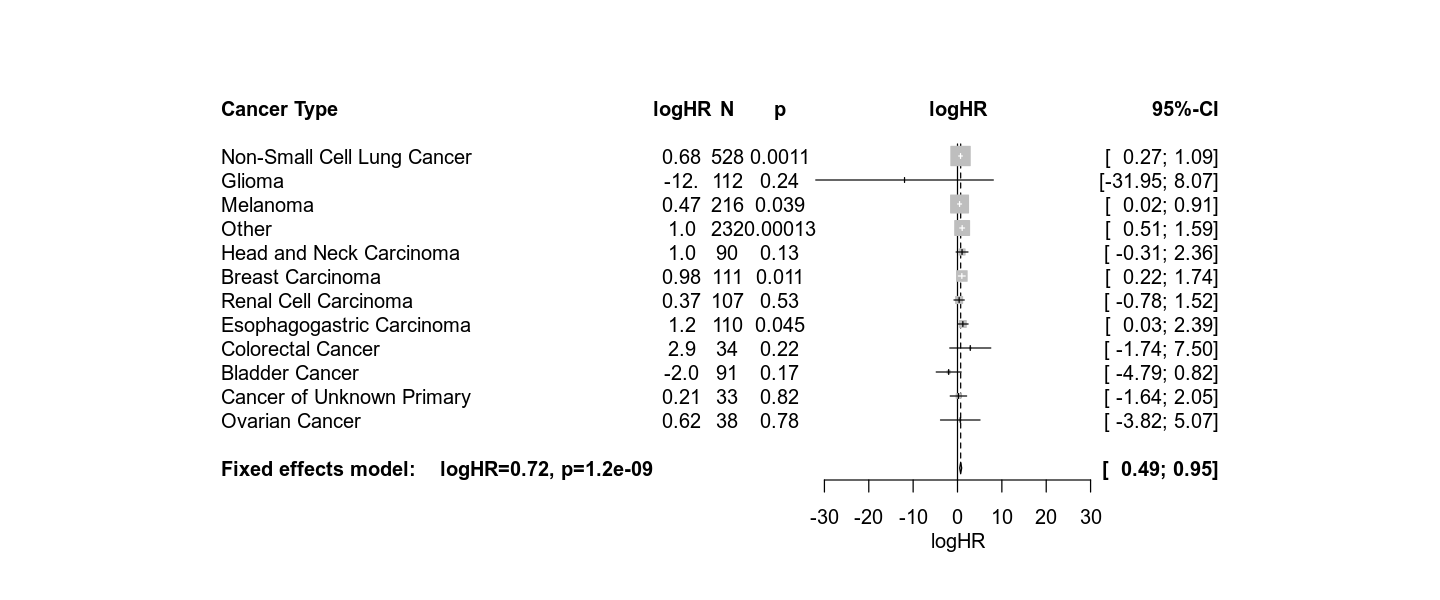

In [555]:
formulas <- list("Non-Small Cell Lung Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Glioma"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Melanoma"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMCTLA4.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Other"="Surv(Tstart,Tstop,status) ~ strata(trans,PANEL_VERSION1) + PANEL_VERSION2 + PROFILE_AFTER_TREATMENT + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMCTLA4.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Head and Neck Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans,START_YEAR2017) + PANEL_VERSION1 + PANEL_VERSION2 + START_YEARbefore2016 + START_YEAR2018 + START_YEARafter2018 + PROFILE_AFTER_TREATMENT + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Breast Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Renal Cell Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans,SEXMALE.1) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Esophagogastric Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans,SEXMALE.1) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1.1",
                 "Colorectal Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans,PROFILE_AFTER_TREATMENT) + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Bladder Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans) + START_YEAR2016 + PROFILE_AFTER_TREATMENT + PANEL_VERSION1 + PANEL_VERSION2 + START_YEAR2017 + START_YEARafter2018 + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Cancer of Unknown Primary"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Ovarian Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEARbefore2016 + START_YEAR2017 + START_YEAR2018 + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1"
                )

meta_df <- data.frame()
for (c in unique(multi$CANCER_TYPE)) {
    form <- formulas[c]
    if (c=="Other") {
        fit <- coxph(as.formula(paste0(form," + rs75824728_norm.1")), multi %>% mutate(PANEL = 1)  %>% pivot_wider(names_from = PANEL_VERSION, values_from = PANEL, values_fill=0, names_prefix="PANEL_VERSION") %>% mutate(ANCESTRY_PC_ASH.1 = as.factor(ntile(ANCESTRY_PC_ASH.1,3))) %>% filter(CANCER_TYPE==c))
    } else if (c=="Esophagogastric Carcinoma") {
        fit <- coxph(as.formula(paste0(form," + rs75824728_norm.1")), multi %>% mutate(ANCESTRY_PC_NS.1 = as.factor(ntile(ANCESTRY_PC_NS.1,2))) %>% mutate(NS = 1)  %>% pivot_wider(names_from = ANCESTRY_PC_NS.1, values_from = NS, values_fill=0, names_prefix="ANCESTRY_PC_NS.1.") %>% filter(CANCER_TYPE==c))
    } else if (c=="Head and Neck Carcinoma") {
        fit <- coxph(as.formula(paste0(form," + rs75824728_norm.1")), multi %>% mutate(PANEL = 1)  %>% pivot_wider(names_from = PANEL_VERSION, values_from = PANEL, values_fill=0, names_prefix="PANEL_VERSION") %>% mutate(START = 1)  %>% pivot_wider(names_from = START_YEAR, values_from = START, values_fill=0, names_prefix="START_YEAR") %>% filter(CANCER_TYPE==c))
    } else if (c=="Bladder Cancer") {
        fit <- coxph(as.formula(paste0(form," + rs75824728_norm.1")), multi %>% mutate(PANEL = 1)  %>% pivot_wider(names_from = PANEL_VERSION, values_from = PANEL, values_fill=0, names_prefix="PANEL_VERSION") %>% mutate(START = 1)  %>% pivot_wider(names_from = START_YEAR, values_from = START, values_fill=0, names_prefix="START_YEAR") %>% filter(CANCER_TYPE==c) %>% mutate(ANCESTRY_ROT_PC2.1 = as.factor(ntile(ANCESTRY_ROT_PC2.1,2))))
    } else if (c=="Ovarian Cancer") {
        fit <- coxph(as.formula(paste0(form," + rs75824728_norm.1")), multi %>% mutate(START = 1)  %>% pivot_wider(names_from = START_YEAR, values_from = START, values_fill=0, names_prefix="START_YEAR") %>% filter(CANCER_TYPE==c) %>% mutate(ANCESTRY_ROT_PC2.1 = as.factor(ntile(ANCESTRY_ROT_PC2.1,2))))
    } else {
        fit <- coxph(as.formula(paste0(form," + rs75824728_norm.1")), multi %>% filter(CANCER_TYPE==c))
    } 
    fit <- summary(fit)
    coef <- fit$coefficients[dim(fit$coefficients)[1],"coef"]
    coef_se <- fit$coefficients[dim(fit$coefficients)[1],"se(coef)"]
    pval <- fit$coefficients[dim(fit$coefficients)[1],"Pr(>|z|)"]
    n <- (temp %>% filter(CANCER_TYPE==c) %>% distinct(ID) %>% dim)[1]
    temp_df <- data.frame(cancer=c, coef=coef, coef_se=coef_se, pval=pval, n=n)
    meta_df <- rbind(meta_df,temp_df)
}

meta <- metagen(coef,coef_se,data=meta_df,studlab=paste(cancer),random=F,fixed=T,method.tau = "SJ",hakn = TRUE,prediction=F,sm="SMD")
meta

meta$n_print <- as.character(as.integer(meta_df$n))
meta$pval_print <- as.character(formatC(signif(as.double(meta_df$pval),2),digits=2,format="fg", flag="#"))
meta$TE_print <- as.character(formatC(signif(as.double(meta_df$coef),2),digits=2,format="fg", flag="#"))
options(repr.plot.width=12, repr.plot.height=5)
forest(meta,colgap=unit(0,"points"),comb.random=F,leftcols=c("studlab","TE_print","n_print","pval_print"),leftlabs=c("Cancer Type","logHR","N","p"),rightcols=c("ci"),ref=0,print.tau2=F,print.pval.Q=F,print.I2=F,smlab="logHR",xlab="logHR",text.fixed=paste("Fixed effects model:    logHR=",signif(meta$TE.fixed,2),", p=",signif(meta$pval.fixed,2),sep=""))

Number of studies combined: k = 12

                       SMD           95%-CI    z  p-value
Common effect model 0.7438 [0.4873; 1.0003] 5.68 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.6559 [0.0000; 1.8897]; tau = 0.8099 [0.0000; 1.3747]
 I^2 = 21.6% [0.0%; 59.8%]; H = 1.13 [1.00; 1.58]

Test of heterogeneity:
     Q d.f. p-value
 14.04   11  0.2308

Details on meta-analytical method:
- Inverse variance method
- Sidik-Jonkman estimator for tau^2
- Q-profile method for confidence interval of tau^2 and tau

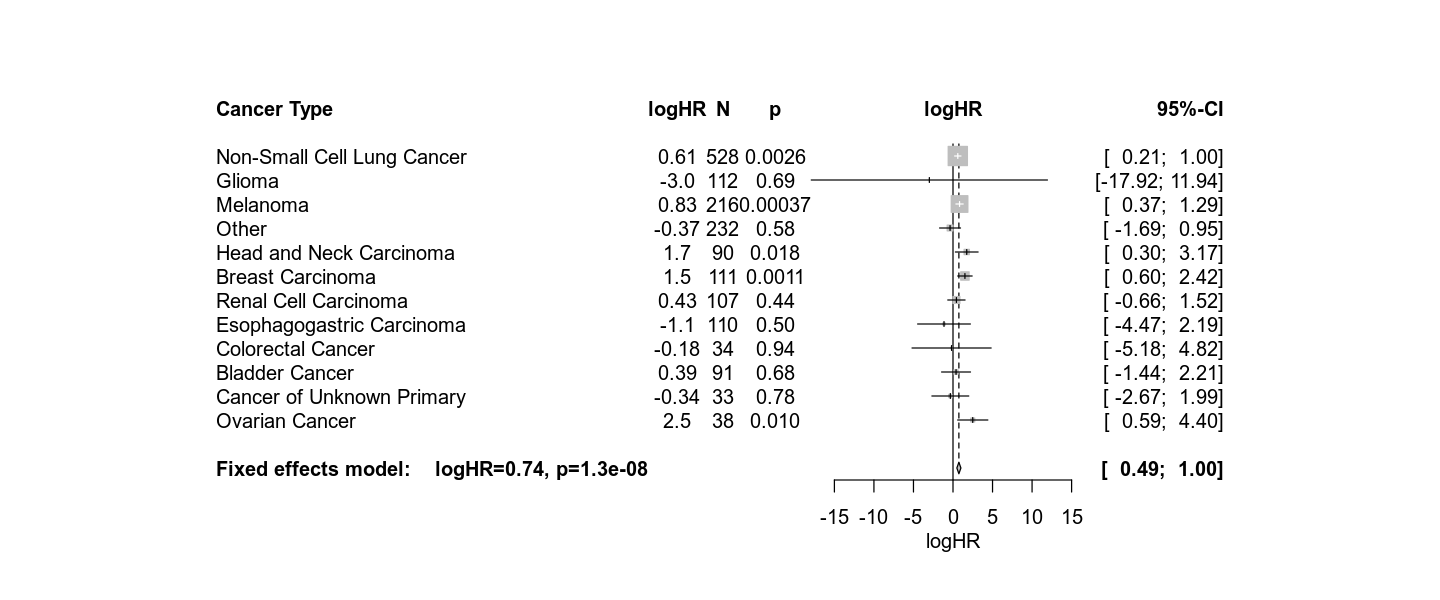

In [558]:
formulas <- list("Non-Small Cell Lung Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Glioma"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Melanoma"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMCTLA4.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Other"="Surv(Tstart,Tstop,status) ~ strata(trans,PANEL_VERSION1) + PANEL_VERSION2 + PROFILE_AFTER_TREATMENT + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMCTLA4.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Head and Neck Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans,START_YEAR2017) + PANEL_VERSION1 + PANEL_VERSION2 + START_YEARbefore2016 + START_YEAR2018 + START_YEARafter2018 + PROFILE_AFTER_TREATMENT + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Breast Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Renal Cell Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans,SEXMALE.1) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Esophagogastric Carcinoma"="Surv(Tstart,Tstop,status) ~ strata(trans,SEXMALE.1) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1.1",
                 "Colorectal Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans,PROFILE_AFTER_TREATMENT) + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Bladder Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans) + START_YEAR2016 + PROFILE_AFTER_TREATMENT + PANEL_VERSION1 + PANEL_VERSION2 + START_YEAR2017 + START_YEARafter2018 + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Cancer of Unknown Primary"="Surv(Tstart,Tstop,status) ~ strata(trans) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR + LINE_OF_TREATMENT + CONC_CHEMO + SEXMALE.1 + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1",
                 "Ovarian Cancer"="Surv(Tstart,Tstop,status) ~ strata(trans,START_YEARbefore2016) + PROFILE_AFTER_TREATMENT + PANEL_VERSION + START_YEAR2017 + START_YEAR2018 + LINE_OF_TREATMENT + CONC_CHEMO + AGE_AT_TREATMENTSTART.1 + TREATMENT_CUMPD1_CTLA4_combo.1 + ANCESTRY_ROT_PC1.1 + ANCESTRY_ROT_PC2.1 + ANCESTRY_PC_ASH.1 + ANCESTRY_PC_NS.1"
                )

meta_df <- data.frame()
for (c in unique(multi$CANCER_TYPE)) {
    form <- formulas[c]
    if (c=="Other") {
        fit <- coxph(as.formula(paste0(form," + rs113861051_norm.1")), multi %>% mutate(PANEL = 1)  %>% pivot_wider(names_from = PANEL_VERSION, values_from = PANEL, values_fill=0, names_prefix="PANEL_VERSION") %>% mutate(ANCESTRY_PC_ASH.1 = as.factor(ntile(ANCESTRY_PC_ASH.1,3))) %>% filter(CANCER_TYPE==c))
    } else if (c=="Esophagogastric Carcinoma") {
        fit <- coxph(as.formula(paste0(form," + rs113861051_norm.1")), multi %>% mutate(ANCESTRY_PC_NS.1 = as.factor(ntile(ANCESTRY_PC_NS.1,2))) %>% mutate(NS = 1)  %>% pivot_wider(names_from = ANCESTRY_PC_NS.1, values_from = NS, values_fill=0, names_prefix="ANCESTRY_PC_NS.1.") %>% filter(CANCER_TYPE==c))
    } else if (c=="Head and Neck Carcinoma") {
        fit <- coxph(as.formula(paste0(form," + rs113861051_norm.1")), multi %>% mutate(PANEL = 1)  %>% pivot_wider(names_from = PANEL_VERSION, values_from = PANEL, values_fill=0, names_prefix="PANEL_VERSION") %>% mutate(START = 1)  %>% pivot_wider(names_from = START_YEAR, values_from = START, values_fill=0, names_prefix="START_YEAR") %>% filter(CANCER_TYPE==c))
    } else if (c=="Bladder Cancer") {
        fit <- coxph(as.formula(paste0(form," + rs113861051_norm.1")), multi %>% mutate(PANEL = 1)  %>% pivot_wider(names_from = PANEL_VERSION, values_from = PANEL, values_fill=0, names_prefix="PANEL_VERSION") %>% mutate(START = 1)  %>% pivot_wider(names_from = START_YEAR, values_from = START, values_fill=0, names_prefix="START_YEAR") %>% filter(CANCER_TYPE==c) %>% mutate(ANCESTRY_ROT_PC2.1 = as.factor(ntile(ANCESTRY_ROT_PC2.1,2))))
    } else if (c=="Ovarian Cancer") {
        fit <- coxph(as.formula(paste0(form," + rs113861051_norm.1")), multi %>% mutate(START = 1)  %>% pivot_wider(names_from = START_YEAR, values_from = START, values_fill=0, names_prefix="START_YEAR") %>% filter(CANCER_TYPE==c) %>% mutate(ANCESTRY_ROT_PC2.1 = as.factor(ntile(ANCESTRY_ROT_PC2.1,2))))
    } else {
        fit <- coxph(as.formula(paste0(form," + rs113861051_norm.1")), multi %>% filter(CANCER_TYPE==c))
    } 
    fit <- summary(fit)
    coef <- fit$coefficients[dim(fit$coefficients)[1],"coef"]
    coef_se <- fit$coefficients[dim(fit$coefficients)[1],"se(coef)"]
    pval <- fit$coefficients[dim(fit$coefficients)[1],"Pr(>|z|)"]
    n <- (temp %>% filter(CANCER_TYPE==c) %>% distinct(ID) %>% dim)[1]
    temp_df <- data.frame(cancer=c, coef=coef, coef_se=coef_se, pval=pval, n=n)
    meta_df <- rbind(meta_df,temp_df)
}

meta <- metagen(coef,coef_se,data=meta_df,studlab=paste(cancer),random=F,fixed=T,method.tau = "SJ",hakn = TRUE,prediction=F,sm="SMD")
meta

meta$n_print <- as.character(as.integer(meta_df$n))
meta$pval_print <- as.character(formatC(signif(as.double(meta_df$pval),2),digits=2,format="fg", flag="#"))
meta$TE_print <- as.character(formatC(signif(as.double(meta_df$coef),2),digits=2,format="fg", flag="#"))
options(repr.plot.width=12, repr.plot.height=5)
forest(meta,colgap=unit(0,"points"),comb.random=F,leftcols=c("studlab","TE_print","n_print","pval_print"),leftlabs=c("Cancer Type","logHR","N","p"),rightcols=c("ci"),ref=0,print.tau2=F,print.pval.Q=F,print.I2=F,smlab="logHR",xlab="logHR",text.fixed=paste("Fixed effects model:    logHR=",signif(meta$TE.fixed,2),", p=",signif(meta$pval.fixed,2),sep=""))